In [116]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio as ug
import scipy.constants as consts
import scipy.optimize as opt

In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=False)

In [3]:
sundata = np.load('Sun2019final.npz')

In [4]:
times = sundata['time']
volts = sundata['volts']

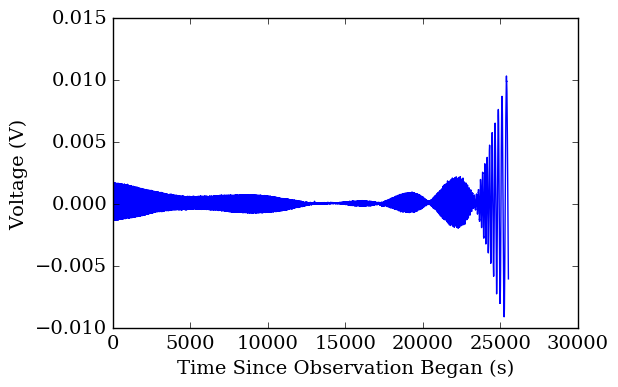

In [5]:
plt.plot(times - times[0], volts)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Since Observation Began (s)')
plt.show()

In [6]:
unixtime = times
JDtime = ug.timing.julian_date(unixtime)
LSTtime = ug.timing.lst(jd = JDtime)*180/np.pi #convert LSTtime from rad to deg # now DEG

In [7]:
#ra = [ug.coord.sunpos(time)[0] for time in JDtime]
#np.savez('SunRAvalues.npz', data=ra)

In [8]:
ra = np.load('SunRAvalues.npz')['data'] #RA in DEG

In [9]:
h2 = LSTtime - ra #DEG
L = ug.coord.nch.lat*np.pi/180 #DEG to RAD
l = consts.c/10.7e9 #m
d = ug.coord.sunpos(JDtime[0])[1]*np.pi/180  #DEG to RAD

In [10]:
h = [] #DEG
for val in h2:
    if val < 0:
        h.append(val+360)
    else:
        h.append(val)

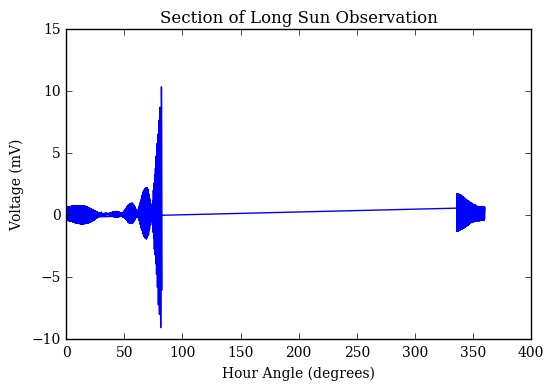

In [11]:
def f(x):
    return np.mean(x)*np.ones(len(x))
%matplotlib inline
plt.plot(h, volts*1000)
#plt.plot(h, f(volts))
plt.title("Section of Long Sun Observation")
plt.ylabel("Voltage (mV)")
plt.xlabel("Hour Angle (degrees)")
plt.savefig("sunsectionall.png")
plt.show()

### Baseline Fitting

Use a combination of Brute Force guessing values of Bew and Bns and Matrix Algebra least-squares to determine the baseline values. 

In [12]:
hsmall = h[500:600]
#voltssmall = voltsfilt[500:600]
voltssmall = volts[500:600]

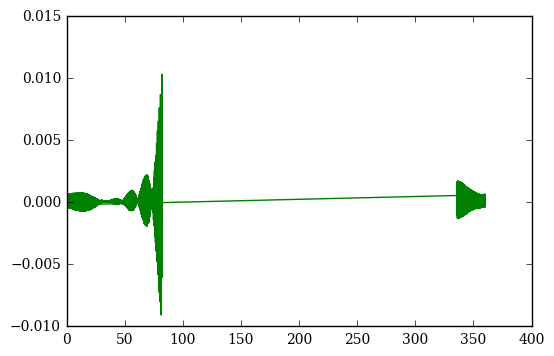

In [13]:
plt.plot(hsmall, voltssmall)
plt.plot(h, volts)
plt.show()

In [14]:
fit = np.polyfit(hsmall, voltssmall, 1)
a = fit[0]
b = fit[1]
print(type(b))

<type 'numpy.float64'>


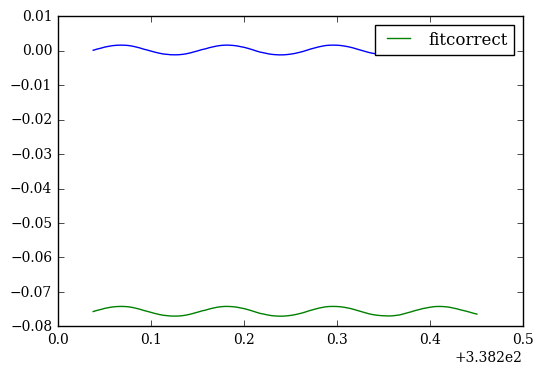

In [15]:
plt.plot(hsmall, voltssmall)
#plt.plot(np.array(hsmall), np.array(hsmall)*a + b)
plt.plot(np.array(hsmall), np.array(voltssmall)-b, label='fitcorrect')
plt.legend()
plt.show()

In [16]:
voltssmall = np.array(voltssmall)

In [17]:
hsmall = np.array(hsmall)*np.pi/180

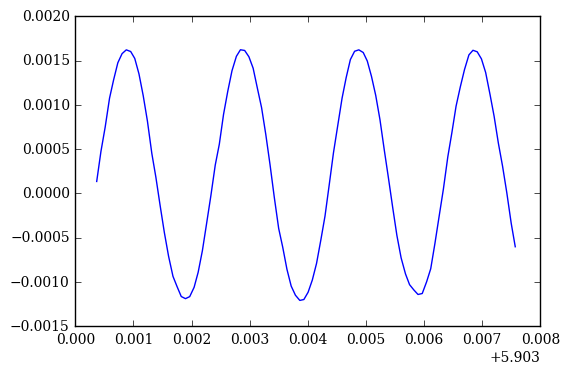

In [18]:
plt.plot(hsmall, voltssmall)
plt.show()

In [19]:
def chisq(ys, mdl, sig):
    ys.shape = (-1,)
    mdl.shape = (-1,)
    return np.sum(np.abs(ys-mdl)**2/sig**2)

#Create Guesses for baseline components
ewvals = np.linspace(13, 22, 800)
nsvals = np.linspace(-2, 2, 400)

#Empty arrays to store results
avals = np.empty((len(ewvals), len(nsvals)), dtype=object)
s = np.empty((len(ewvals), len(nsvals)))
var = np.empty((len(ewvals), len(nsvals)), dtype=object)
chi = np.empty((len(ewvals), len(nsvals)))

Y = voltssmall
Y.shape = (-1, 1)

#Loop over the least squares process for
#Each guess of EW and each guess of NS
for i in range(len(ewvals)):
    for j in range(len(nsvals)):
        
        #Set Baseline components to current guess
        Bew = ewvals[i]
        Bns = nsvals[j]
        
        Qew = Bew*np.cos(d)/l
        Qns = Bns*np.sin(L)*np.cos(d)/l
        nutaug = Qew*np.sin(hsmall) + Qns*np.cos(hsmall)
        aterm = np.cos(2*np.pi*nutaug)
        bterm = np.sin(2*np.pi*nutaug)
        
        #perform least squares
        Xt = np.vstack((aterm, bterm))
        X = Xt.T
        xx = np.dot(Xt, X)
        xy = np.dot(Xt, Y)
        xxi = np.linalg.inv(xx)
        a = np.dot(xxi, xy)
        avals[i,j] = tuple(a)
        
        ybar = np.dot(X, a)
        dely = Y - ybar
        s_sq = np.dot(dely.T, dely)/(len(Y) - 2)
        s[i,j] = s_sq
        
        dxxi = np.diag(xxi)
        vardc = s_sq*dxxi
        var[i,j] = vardc
        
        #Calculate X^2 value
        X2 = chisq(Y, ybar, np.sqrt(s_sq))
        chi[i,j] = X2
         
    if (i%100 == 0):
        print(i)

0
100
200
300
400
500
600
700


In [20]:
minns = [(min(x), list(x).index(min(x))) for x in s] 
nsindex = [x[1] for x in minns]
vvals = [x[0] for x in minns]
ewindexval = list(vvals).index(min(vvals))
indexval = (ewindexval, nsindex[ewindexval])
indexval

(141, 393)

In [21]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.5882352941
1.93984962406


<IPython.core.display.Javascript object>


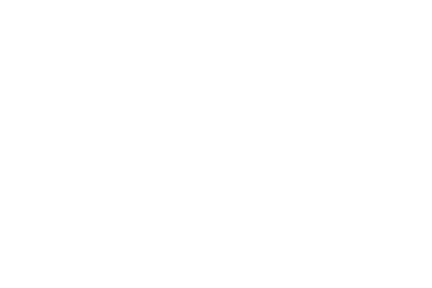

<IPython.core.display.Javascript object>


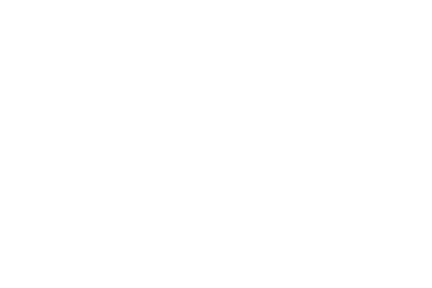

In [270]:
%matplotlib notebook
plt.imshow(chi-97,interpolation='none', cmap = 'gnuplot', aspect='auto', extent=[-2,2,22,13], vmax=1)
plt.plot()
plt.colorbar()

In [271]:
minns = [(min(x), list(x).index(min(x))) for x in vvals]
nsindex = [x[1] for x in minns]
vvals = [x[0] for x in minns]
ewindexval = list(vvals).index(min(vvals))
indexval = (ewindexval, nsindex[ewindexval])

TypeError: 'numpy.float64' object is not iterable

In [22]:
indexval

(141, 393)

In [23]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

14.5882352941
1.93984962406


In [24]:
3*np.sqrt(var[indexval])

array([  8.63431201e-05,   8.90730919e-05])

In [25]:
var[indexval]

array([  8.28348265e-10,   8.81557300e-10])

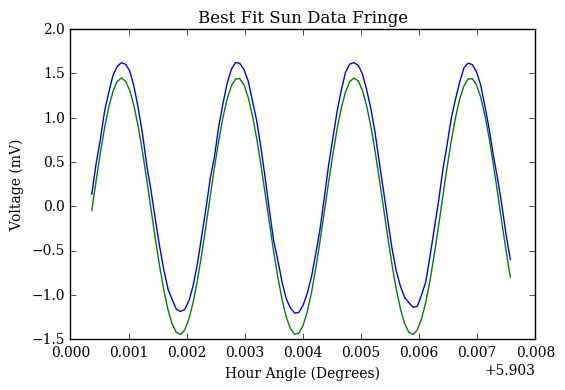

In [26]:
%matplotlib inline
voltssmall.shape = (100,)
Bew = ewvals[indexval[0]]
Bns = nsvals[indexval[1]]
Qew = Bew*np.cos(d)/l
Qns = Bns*np.sin(L)*np.cos(d)/l
nutaug = Qew*np.sin(hsmall) + Qns*np.cos(hsmall)
aterm = np.cos(2*np.pi*nutaug)
bterm = np.sin(2*np.pi*nutaug)
A, B = avals[indexval]
plt.plot(hsmall, voltssmall*1000, label='Data')
plt.plot(hsmall, (A*aterm+B*bterm)*1000, label='Model')
plt.subplot()
#plt.legend(loc = 'lower left')
plt.ylabel('Voltage (mV)')
plt.xlabel('Hour Angle (Degrees)')
plt.title('Best Fit Sun Data Fringe')
plt.savefig('VoltageFit12000.png')
plt.show()

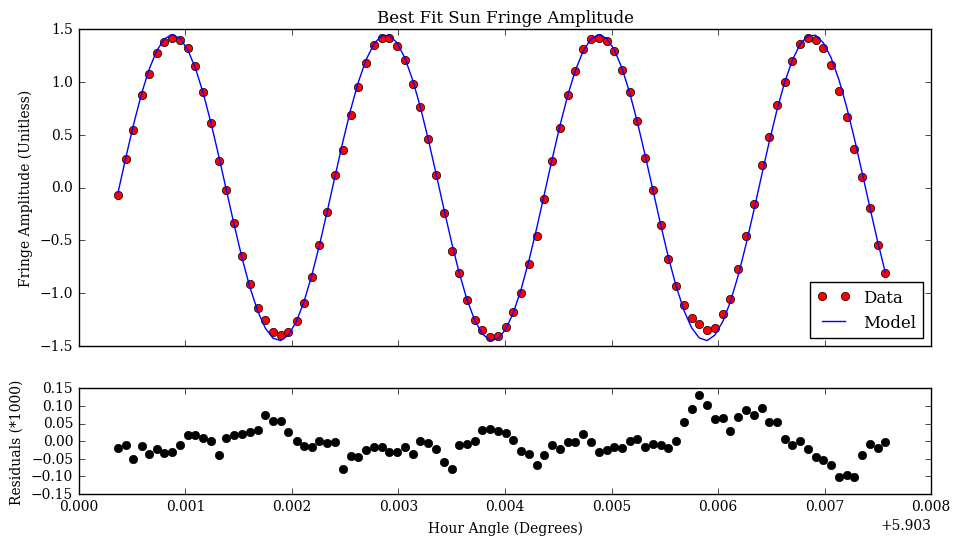

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0.2)
ax1 = axs[0]
ax1.plot(hsmall, (voltssmall-0.65*np.mean(voltssmall))*1000, 'ro', label='Data')
ax1.plot(hsmall, (A*aterm+B*bterm)*1000, label='Model')
ax1.title.set_text("Best Fit Sun Fringe Amplitude")
ax1.set_ylabel("Fringe Amplitude (Unitless)")
ax1.legend(loc='lower right')
ax2 = axs[1]
ax2.plot(hsmall, 1000*((voltssmall-0.65*np.mean(voltssmall) - (A*aterm+B*bterm))), 'ko')
#ax2.set_ylim(-0.25, 0.1)
ax2.set_ylabel("Residuals (*1000)")
plt.xlabel("Hour Angle (Degrees)")
plt.savefig('BaselineFitWithResiduals.pdf')
plt.show()

In [28]:
np.mean((voltssmall-0.65*np.mean(voltssmall) - (A[0]*aterm+B[0]*bterm)))*1000

IndexError: invalid index to scalar variable.

## Calculating Errors

In [ ]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

sig = 1. # Let's assume \sigma_i^2=1 for now
ps = [(1,1),(2,1),(1,2),(2,2)]
X2 = [chisq(ys, f(xs,*p), sig) for p in ps]
print('Chi-Square:', np.around(X2,2))

# Diameter Fitting

### First Data collection attempt showed lobed structure in powe spectra and noisy data

In [29]:
badsun = np.load('BigSunfinal.npz')
badtimes = badsun['time'][:220]
badvolts = badsun['volts'][:220]

In [30]:
len(badtimes)

220

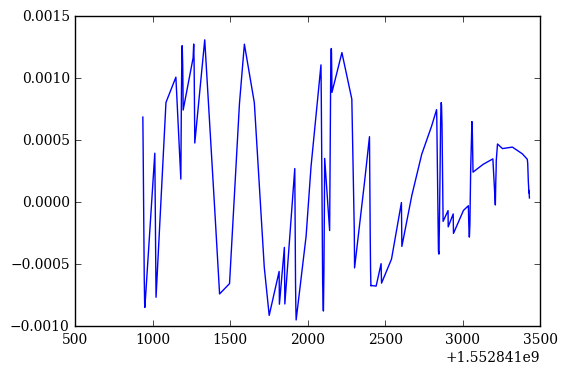

In [31]:
plt.plot(badtimes,badvolts)

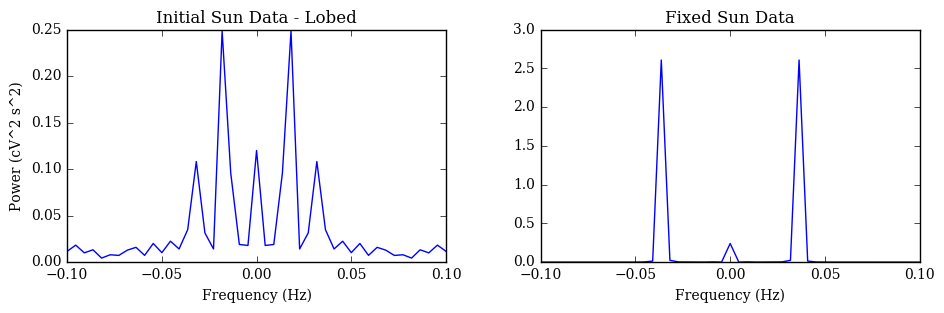

In [32]:
badfvolts = np.fft.fft(badvolts)
badpower = np.abs(badfvolts)**2
badfreq = np.fft.fftfreq(len(badfvolts))
fvolts = np.fft.fft(volts[:220])
power = np.abs(fvolts)**2
freq = np.fft.fftfreq(len(fvolts))
fig, axs = plt.subplots(1, 2, sharey=False, gridspec_kw = {'height_ratios':[1, 1]}, figsize = (11, 6))
fig.subplots_adjust(wspace=0.25)
ax1 = axs[0]
ax1.plot(np.fft.fftshift(badfreq), np.fft.fftshift(badpower)*100)
ax1.set_title('Initial Sun Data - Lobed')
ax1.set_xlim((-0.1, 0.1))
ax1.set_ylabel("Power (cV^2 s^2)")
ax1.set_xlabel("Frequency (Hz)")
ax2 = axs[1]
ax2.plot(np.fft.fftshift(freq), np.fft.fftshift(power)*100)
ax2.set_title('Fixed Sun Data')
ax2.set_xlabel("Frequency (Hz)")
ax2.set_xlim((-0.1, 0.1))
plt.savefig('SunPower.pdf', bbox_inches="tight")
plt.show()

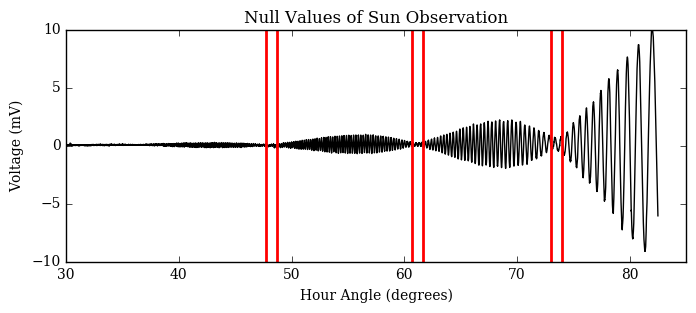

In [99]:
plt.figure(figsize=(8,3)) 
plt.plot(h[6000:], volts[6000:]*1000, 'k-')
#plt.plot(h, f(volts))
plt.title("Null Values of Sun Observation")
plt.ylabel("Voltage (mV)")
plt.xlabel("Hour Angle (degrees)")
plt.xlim(30, 85)
plt.ylim((-10, 10))
#plt.axvline(73.5, color='red', linewidth=2)
plt.axvline(73.5-0.5, color='red',linewidth=2)
plt.axvline(73.5+0.5, color='red',linewidth=2)
#plt.axvline(61.2,color='red',linewidth=2)
plt.axvline(61.2-0.5, color='red',linewidth=2)
plt.axvline(61.2+0.5, color = 'red',linewidth=2)
#plt.axvline(48.2,color='red',linewidth=2)
plt.axvline(48.2-0.5, color='red',linewidth=2)
plt.axvline(48.2+0.5, color='red',linewidth=2)
#plt.axvline(36.7,color='red',linewidth=2)
plt.savefig("sunnulls.pdf", bbox_inches='tight')

## Calculate R for intermediate values

In [129]:
def Rfunc(u, R):
    return -2*np.pi*u*R

In [141]:
bx = ewvals[indexval[0]]
l = consts.c/10.7e9
hnulls = np.array([73.5, 61.2, 48.0])
x = [-3.8317, -7.0156, -10.1735]
u = bx*np.cos(hnulls*np.pi/180)/l
print(u)
R = x/(2*np.pi*u)
midR = np.mean(-2*180*np.array(R)/np.pi)

[ 147.87938604  250.83657936  348.39886329]


In [140]:
x - Rfunc(u, 0.5)

array([  460.74509281,   781.01075496,  1084.35380943])

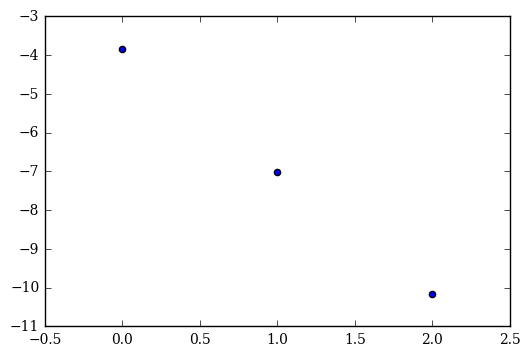

In [139]:
plt.scatter(range(len(x)),x)


In [145]:
param, cov = opt.curve_fit(Rfunc, u, x)
param[0]*2*180/np.pi

0.51933677463671957

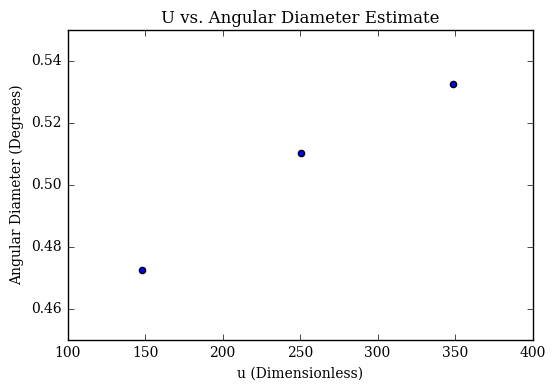

In [133]:
plt.scatter(u, -2*180*R/np.pi)
plt.title('U vs. Angular Diameter Estimate')
plt.ylabel('Angular Diameter (Degrees)')
plt.xlabel('u (Dimensionless)')
plt.show()

## Lower Bound

In [106]:
bx = ewvals[indexval[0]]
l = consts.c/10.7e9
hnulls = np.array([73.5, 61.2, 48.0])-0.5
x = [-3.8317, -7.0156, -10.1735]
u = bx*np.cos(hnulls*np.pi/180)/l
R = x/(2*np.pi*u)
lowerR = np.mean(-2*180*np.array(R)/np.pi)
lowerR

0.49621898835258843

## Upper Bound                                                                                          

In [108]:
bx = ewvals[indexval[0]]
l = consts.c/10.7e9
hnulls = np.array([73.5, 61.2, 48.0])+0.5
x = [-3.8317, -7.0156, -10.1735]
u = bx*np.cos(hnulls*np.pi/180)/l
R = x/(2*np.pi*u)
upperR = np.mean(-2*180*np.array(R)/np.pi)
upperR

0.51435018225327889

In [110]:
midR - lowerR

0.0088499816001282317

In [112]:
midR - upperR

-0.0092812123005622249

In [113]:
midR 

0.50506896995271666

In [ ]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

sig = 0.5 
